## pretrained ResNet implementation 

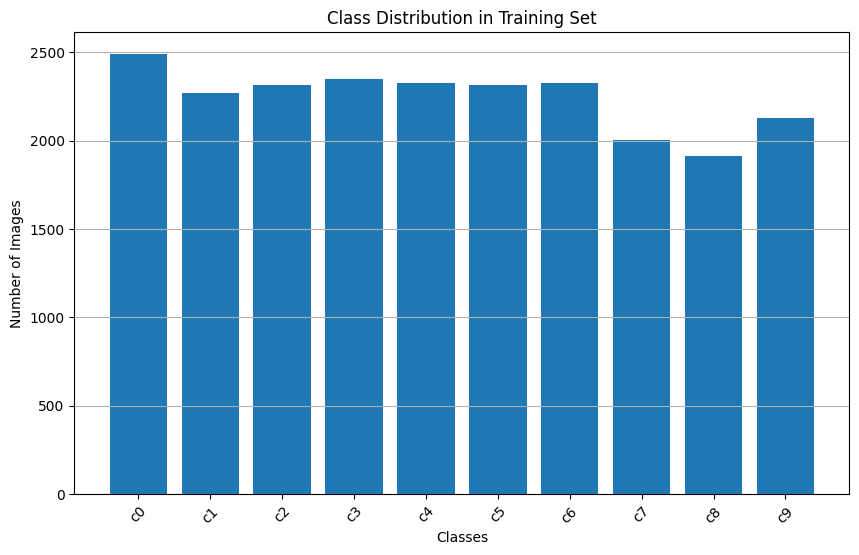

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter

# Hyperparameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64  # Adjust based on GPU memory
EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_CLASSES = 10

# Dataset Paths (update with your dataset paths)
train_dir = '/Users/samuel/CS5640/FinalProjectPt2/state-farm-distracted-driver-detection/imgs/train'
test_dir = '/Users/samuel/CS5640/FinalProjectPt2/state-farm-distracted-driver-detection/imgs/test'


# Data Augmentation and Preprocessing
transform_train = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_HEIGHT, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Data
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=train_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Visualize Class Distribution
train_labels = [train_dataset.targets[i] for i in range(len(train_dataset))]
class_counts_train = Counter(train_labels)
class_names = train_dataset.classes
class_counts_named_train = {class_names[key]: value for key, value in class_counts_train.items()}

plt.figure(figsize=(10, 6))
plt.bar(class_counts_named_train.keys(), class_counts_named_train.values())
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()


## Create ResNet and train 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import random

# Set Random Seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dataset Paths- Update with your paths
train_dir = '/Users/samuel/CS5640/FinalProjectPt2/state-farm-distracted-driver-detection/imgs/train'

# Hyperparameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATIENCE = 10  # Early stopping patience

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation
transform_train = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(IMG_HEIGHT, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Data
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Weighted Sampling
train_labels = [train_dataset.targets[i] for i in train_subset.indices]
class_counts = Counter(train_labels)
sample_weights = [1.0 / class_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# ResNet Model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler()

# Training and Validation
best_val_loss = float('inf')
early_stop_counter = 0
best_model_path = "best_resnet_model.pth"

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved Best Model at Epoch {epoch + 1}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f"Early Stopping at Epoch {epoch + 1}")
            break

    scheduler.step(val_loss)

# Load Best Model
model.load_state_dict(torch.load(best_model_path))
print("Best Model Loaded.")

# Evaluate and Plot
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=train_dataset.classes))

/var/folders/8q/w3n8_d9j4p74p399mm4pdcbh0000gn/T/ipykernel_62525/3710190918.py:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/var/folders/8q/w3n8_d9j4p74p399mm4pdcbh0000gn/T/ipykernel_62525/3710190918.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/var/folders/8q/w3n8_d9j4p74p399mm4pdcbh0000gn/T/ipykernel_62525/3710190918.py:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/30, Train Loss: 0.2705, Val Loss: 0.0526, Val Accuracy: 0.9855
Saved Best Model at Epoch 1
Epoch 2/30, Train Loss: 0.0277, Val Loss: 0.0267, Val Accuracy: 0.9935
Saved Best Model at Epoch 2
Epoch 3/30, Train Loss: 0.0136, Val Loss: 0.0368, Val Accuracy: 0.9886
Epoch 4/30, Train Loss: 0.0118, Val Loss: 0.0311, Val Accuracy: 0.9909
Epoch 5/30, Train Loss: 0.0096, Val Loss: 0.0200, Val Accuracy: 0.9949
Saved Best Model at Epoch 5
Epoch 6/30, Train Loss: 0.0068, Val Loss: 0.0179, Val Accuracy: 0.9951
Saved Best Model at Epoch 6
Epoch 7/30, Train Loss: 0.0077, Val Loss: 0.0231, Val Accuracy: 0.9949
Epoch 8/30, Train Loss: 0.0076, Val Loss: 0.0139, Val Accuracy: 0.9971
Saved Best Model at Epoch 8
Epoch 9/30, Train Loss: 0.0064, Val Loss: 0.0240, Val Accuracy: 0.9933
Epoch 10/30, Train Loss: 0.0043, Val Loss: 0.0191, Val Accuracy: 0.9953
Epoch 11/30, Train Loss: 0.0035, Val Loss: 0.0187, Val Accuracy: 0.9955
Epoch 12/30, Train Loss: 0.0039, Val Loss: 0.0113, Val Accuracy: 0.9975
Saved

/var/folders/8q/w3n8_d9j4p74p399mm4pdcbh0000gn/T/ipykernel_62525/3710190918.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model

## Visualize some predictions 

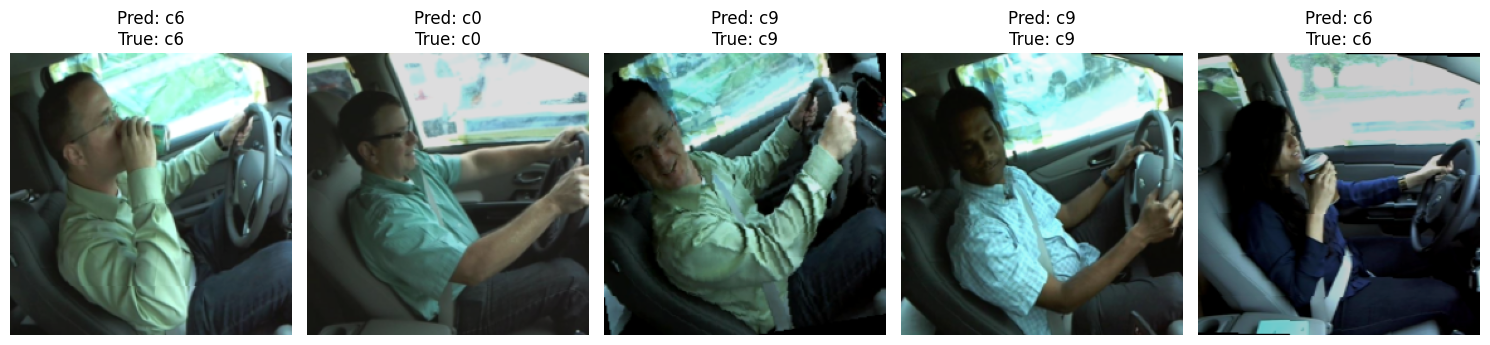

In [8]:
import random
import matplotlib.pyplot as plt

# Function to visualize predictions for ResNet
def visualize_predictions_resnet(model, data_loader, device, class_names, num_images=5):
    model.eval()  # Set model to evaluation mode
    images_shown = 0

    # Create a figure
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    axs = axs.flatten()

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for idx in range(images.size(0)):
                if images_shown >= num_images:
                    break

                # Move image to CPU for plotting
                img = images[idx].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
                img = img.clip(0, 1)

                # Plot image and predictions
                axs[images_shown].imshow(img)
                axs[images_shown].axis('off')
                axs[images_shown].set_title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")
                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

# Class names from the dataset
class_names = train_dataset.classes  # Automatically extracted from the dataset folder structure

# Visualize 5 random predictions using ResNet
visualize_predictions_resnet(model, val_loader, device, class_names, num_images=5)

## Create submission file 


In [ ]:
import os
import csv
import torch
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Dataset Paths- Update with your paths
test_dir = '/Users/samuel/CS5640/FinalProjectPt2/state-farm-distracted-driver-detection/imgs/test'
best_model_path = "/Users/samuel/CS5640/SamuelBlakeFinal/distracted-driving-behaviors/Resnet/best_resnet_model.pth"
submission_file = "/Users/samuel/CS5640/FinalProjectPt2/state-farm-distracted-driver-detection/Custom_Resnet/resnet_submission.csv"

# Hyperparameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
NUM_CLASSES = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Transformations
transform_val_test = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

# ResNet Model
def get_resnet_model(num_classes):
    model = models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model

# Function to Process a Batch of Images
def process_batch(image_paths):
    images = []
    img_names = []
    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        img = Image.open(img_path).convert("RGB")
        img = transform_val_test(img)
        images.append(img)
        img_names.append(img_name)

    images = torch.stack(images).to(device)
    return images, img_names

# Ensure Directory Exists for Saving Model
directory = os.path.dirname(best_model_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    logging.info(f"Directory {directory} created.")

# Check if Model File Exists Before Loading
if os.path.exists(best_model_path):
    logging.info("Loading the best ResNet model...")
    best_model = get_resnet_model(NUM_CLASSES).to(device)
    best_model.load_state_dict(torch.load(best_model_path, map_location=device))
    best_model.eval()
    logging.info("Model loaded successfully.")
else:
    logging.error(f"Model file {best_model_path} not found. Please train and save the model first.")
    raise FileNotFoundError(f"{best_model_path} not found.")

# Load Test Data
logging.info("Reading test images...")
test_image_paths = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
if len(test_image_paths) == 0:
    raise ValueError("No valid image files found in the test directory!")
logging.info(f"Found {len(test_image_paths)} test images.")

# Generate Predictions and Save to CSV
logging.info("Generating predictions...")
fieldnames = ["img"] + [f"c{i}" for i in range(NUM_CLASSES)]

with open(submission_file, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for i in tqdm(range(0, len(test_image_paths), BATCH_SIZE), desc="Processing Batches", unit="batch"):
        batch_paths = test_image_paths[i:i + BATCH_SIZE]
        images, img_names = process_batch(batch_paths)

        with torch.no_grad():
            outputs = best_model(images)
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()

        for j, img_name in enumerate(img_names):
            row = {"img": img_name}
            row.update({f"c{k}": probabilities[j][k] for k in range(NUM_CLASSES)})
            writer.writerow(row)

logging.info(f"Submission file '{submission_file}' created successfully.")

2024-12-03 18:38:10,378 - INFO - Using device: cpu
2024-12-03 18:38:10,381 - ERROR - Model file /Users/samuel/CS5640/SamuelBlakeFinal/distracted-driving-behaviors/Custom_Resnet/best_resnet_model.pth not found. Please train and save the model first.


FileNotFoundError: /Users/samuel/CS5640/SamuelBlakeFinal/distracted-driving-behaviors/Custom_Resnet/best_resnet_model.pth not found.